# **Graph Workflows**

## **What's Covered?**
1. Sequential Graph
2. Conditional Graph
3. Conditional Looping Graph

## **Conditional Graph**

In [1]:
# Step 1: Defining a State
from typing import TypedDict, Literal

class TaxState(TypedDict):
    # INPUTS
    income: float
    regime: str  # "new" or "old"
    
    # OUTPUTS
    tax_payable: float
    calculation_log: str  # To explain how we got the number

In [11]:
# Step 2: Defining graph nodes
def new_regime_node(state: TaxState):
    income = state["income"]
    tax = 0.0
    
    # Standard Deduction for New Regime
    taxable_income = max(0, income - 75000)
    
    # Logic: 0-3L Nil, 3-7L 5%, 7-10L 10%, 10-12L 15%, 12-15L 20%, >15L 30%
    if taxable_income <= 300000:
        tax = 0
    elif taxable_income <= 700000:
        tax = (taxable_income - 300000) * 0.05
    elif taxable_income <= 1000000:
        tax = (400000 * 0.05) + (taxable_income - 700000) * 0.10
    elif taxable_income <= 1200000:
        tax = (400000 * 0.05) + (300000 * 0.10) + (taxable_income - 1000000) * 0.15
    elif taxable_income <= 1500000:
        tax = (400000 * 0.05) + (300000 * 0.10) + (200000 * 0.15) + (taxable_income - 1200000) * 0.20
    else:
        # Complex calculation for >15L
        tax = (400000 * 0.05) + (300000 * 0.10) + (200000 * 0.15) + (300000 * 0.20) + (taxable_income - 1500000) * 0.30

    return {
        "tax_payable": tax, 
        "calculation_log": f"Calculated using NEW Regime (Standard Deduction applied). Taxable Income: {taxable_income}"
    }

In [3]:
def old_regime_node(state: TaxState):
    income = state["income"]
    tax = 0.0
    
    # Assumption: User claims typical 80C/80D deductions approx 1.5L for this simplified example
    # In a real app, we would take these as inputs.
    taxable_income = max(0, income - 150000 - 50000) # 80C + Std Ded
    
    # Logic: 0-2.5L Nil, 2.5-5L 5%, 5-10L 20%, >10L 30%
    if taxable_income <= 250000:
        tax = 0
    elif taxable_income <= 500000:
        tax = (taxable_income - 250000) * 0.05
    elif taxable_income <= 1000000:
        tax = (250000 * 0.05) + (taxable_income - 500000) * 0.20
    else:
        tax = (250000 * 0.05) + (500000 * 0.20) + (taxable_income - 1000000) * 0.30

    return {
        "tax_payable": tax, 
        "calculation_log": f"Calculated using OLD Regime (80C+Std Ded applied). Taxable Income: {taxable_income}"
    }

In [4]:
def route_tax_regime(state: TaxState) -> Literal["new_regime", "old_regime"]:
    # Simply check the user's string input
    choice = state["regime"].lower().strip()
    
    if choice == "new":
        return "new_regime"
    else:
        return "old_regime"

In [7]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(TaxState)

builder.add_node("new_regime", new_regime_node)
builder.add_node("old_regime", old_regime_node)

# The Conditional Logic
builder.add_conditional_edges(
    START,              # From the start...
    route_tax_regime    # ...run this function to decide where to go
)

builder.add_edge("new_regime", END)
builder.add_edge("old_regime", END)

# Step 4: Compile the graph
app = builder.compile()

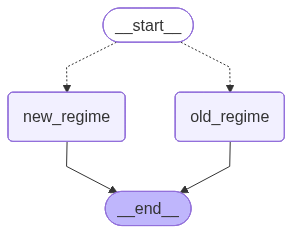

In [8]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
app.invoke({"income": 1200000, "regime": "new"})

{'income': 1200000,
 'regime': 'new',
 'tax_payable': 68750.0,
 'calculation_log': 'Calculated using NEW Regime (Standard Deduction applied). Taxable Income: 1125000'}

In [10]:
app.invoke({"income": 1200000, "regime": "old"})

{'income': 1200000,
 'regime': 'old',
 'tax_payable': 112500.0,
 'calculation_log': 'Calculated using OLD Regime (80C+Std Ded applied). Taxable Income: 1000000'}

## **Example**

Smart Customer Support Triage

The Workflow Logic

    Input: A raw customer email.

    Node 1 (The Triage Agent): An LLM reads the email and categorizes it (Refund vs. Technical vs. General).

    Router: Checks the category and sends it to the correct department.

    Node 2 (The Specialist): A specialized LLM drafts the response.

        Refund Agent: Empathetic, asks for Order ID.

        Tech Agent: Analytical, asks for logs/screenshots.

        General Agent: Friendly, provides links.

In [ ]:
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END

# Initialize LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# --- PROMPT 1: THE CLASSIFIER ---
# It must return EXACTLY one of these strings.
triage_prompt = ChatPromptTemplate.from_template(
    """You are a Support Triage Bot. Analyze this ticket:
    "{ticket}"
    
    Classify it into one of these three categories:
    - REFUND (If user asks for money back or is angry about billing)
    - TECH (If user has bugs, crashes, or login issues)
    - GENERAL (For pricing, feature questions, or "how to")
    
    Return ONLY the category name. Do not add punctuation."""
)
triage_chain = triage_prompt | llm | StrOutputParser()

# --- PROMPT 2: THE SPECIALISTS ---
refund_prompt = ChatPromptTemplate.from_template(
    "You are a Billing Support Agent. Write a polite, empathetic response to this angry user: {ticket}. Ask for their Order ID."
)
tech_prompt = ChatPromptTemplate.from_template(
    "You are a Technical Engineer. Analyze this bug report: {ticket}. Ask for their OS version and Console Logs. Be concise."
)
general_prompt = ChatPromptTemplate.from_template(
    "You are a General Info Bot. Answer this query cheerily: {ticket}. Refer them to help.example.com."
)

# Chains
refund_chain = refund_prompt | llm | StrOutputParser()
tech_chain = tech_prompt | llm | StrOutputParser()
general_chain = general_prompt | llm | StrOutputParser()

In [ ]:
class SupportState(TypedDict):
    ticket: str         # Input
    category: str       # Determined by Triage Node
    response: str       # Final Output

# --- NODE 1: TRIAGE ---
def triage_node(state: SupportState):
    ticket = state["ticket"]
    # Run the classification chain
    category = triage_chain.invoke({"ticket": ticket})
    
    # Clean up output just in case (remove spaces/newlines)
    clean_category = category.strip().upper()
    print(f"   [Triage] Ticket classified as: {clean_category}")
    
    return {"category": clean_category}

# --- NODE 2: SPECIALISTS ---
def handle_refund(state: SupportState):
    print("   [Refund Agent] Processing billing request...")
    res = refund_chain.invoke({"ticket": state["ticket"]})
    return {"response": res}

def handle_tech(state: SupportState):
    print("   [Tech Support] Debugging issue...")
    res = tech_chain.invoke({"ticket": state["ticket"]})
    return {"response": res}

def handle_general(state: SupportState):
    print("   [General Info] Answering query...")
    res = general_chain.invoke({"ticket": state["ticket"]})
    return {"response": res}

In [ ]:
def route_ticket(state: SupportState) -> Literal["handle_refund", "handle_tech", "handle_general"]:
    cat = state["category"]
    
    if "REFUND" in cat:
        return "handle_refund"
    elif "TECH" in cat:
        return "handle_tech"
    else:
        return "handle_general"

In [ ]:
builder = StateGraph(SupportState)

# Add Nodes
builder.add_node("triage", triage_node)
builder.add_node("handle_refund", handle_refund)
builder.add_node("handle_tech", handle_tech)
builder.add_node("handle_general", handle_general)

# Start -> Triage
builder.add_edge(START, "triage")

# Conditional Edge
builder.add_conditional_edges(
    "triage",        # Source
    route_ticket     # Logic Function
)

# All specialists go to End
builder.add_edge("handle_refund", END)
builder.add_edge("handle_tech", END)
builder.add_edge("handle_general", END)

app = builder.compile()

In [ ]:
email = "I hate this software! It charged me twice! Give me my money back now!"
result = app.invoke({"ticket": email})
print(f"\nFINAL REPLY:\n{result['response']}")

In [ ]:
email = "My app crashes whenever I try to upload a PDF file."
result = app.invoke({"ticket": email})
print(f"\nFINAL REPLY:\n{result['response']}")